weaves - Revolut Challenge

This notebook provides analysis for Part II - Engagedness measurement

It uses a local module rvlt which provides a data generation routine for an arbitrary PDF

In [116]:
import numpy as np
import pandas as pd
import math

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

import matplotlib
from cycler import cycler
import matplotlib.pyplot as plt

# this is the local Utility module
import rvlt

%load_ext autoreload
%autoreload 2

pd.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.24.2'

In [2]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Tables to fetch from q/kdb+
tbls = ("ttdays0", "users2", "ntfs0", "ntfs1" )

In [4]:
# URL build function
urlf = lambda x: str.format("http://j1:4444/q.csv?{}", x)

In [5]:
# List for Excel - use text import and pass the URL as the filename (don't use web import)
[ urlf(x) for x in tbls]

['http://j1:4444/q.csv?ttdays0',
 'http://j1:4444/q.csv?users2',
 'http://j1:4444/q.csv?ntfs0',
 'http://j1:4444/q.csv?ntfs1']

In [6]:
# Try and fit tdays0 to a distribution
c = pd.read_csv(urlf(tbls[0]))
c.head()
data = pd.Series(c['x'], index=c['tdays0'])
data = pd.Series(c['x'])
data.head()
len(data)
all(data > 0.5)

,tdays0,x
0,1,176
1,2,939
2,3,1021
3,4,902
4,5,875


0     176
1     939
2    1021
3     902
4     875
Name: x, dtype: int64

604

True

<Figure size 864x576 with 0 Axes>

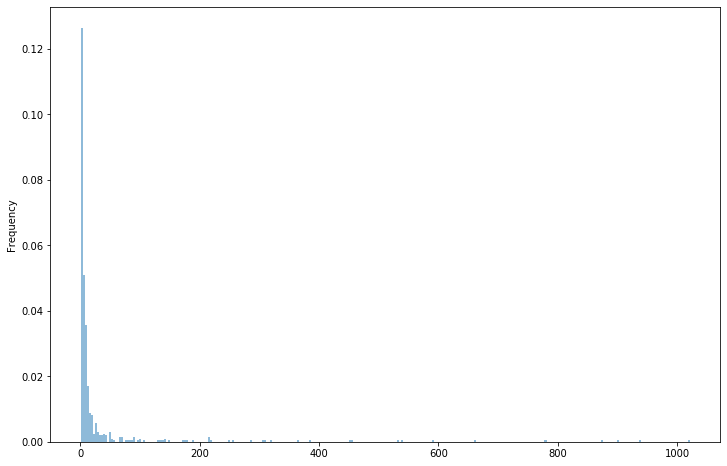

In [134]:
# Plot for comparison
bins=math.floor(len(data)/2)

plt.figure(figsize=(12,8))
data.plot(kind='hist', bins=bins, density=True, alpha=0.5)

In [163]:
# Try a variety of pareto-like distributions to see what fits the data best. 
# The commented numbers are the recorded SSE 
# The best fit is the inverse Weibull (Frecht) but it has infinite mean and variance.
distribution = st.weibull_min # 0.026744602482763516
distribution = st.weibull_max # 0.11059876836774153
distribution = st.wald # 0.04321951887147501 good shape 0.004286143389295488
distribution = st.pareto # 0.004500105346672364 0.00030974282763696146 0.0004970887541559099
distribution = st.invgauss # 0.0042553838908376595 0.0003295758342573526 0.00029231504502302705 0.0006448498305976865
distribution = st.invweibull # 0.08741126234883718 0.00019755557973632042
distribution = st.genextreme # 0.04823740732286759 0.00019752473779033813
distribution = st.loglaplace # 0.013750924203496164 0.00011770092369544237
distribution = st.invweibull # 0.08741126234883718 0.00019755557973632042
distribution = st.invgauss # 0.00037693053502781327
distribution = st.wald # 0.0069594755869143736 good shape 
# distribution = 

params = (0.0, 1.0)
sse = np.inf

In [167]:
# fit dist to data
params = distribution.fit(data)

# Separate parts of parameters
arg = params[:-2]
loc = params[-2]
scale = params[-1]
(arg, loc, scale)

((), -3.3586589468247747, 22.376324193541645)

In [168]:
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0 # roll rotates the data

# Calculate fitted PDF and error with fit in distribution
# pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
pdf = distribution.pdf(x, *arg, loc=loc, scale=scale)
sse = np.sum(np.power(y - pdf, 2.0))
sse

0.0069594755869143736

In [169]:
# My plot method for an arbitrary PDF returns a series "points of the PDF"
ppdf = rvlt.Utility().instance().make_pdf(distribution, params, ppfs=(0.0001, 0.95))
ppdf.head()

-2.040823    0.000677
-2.034416    0.000700
-2.028008    0.000724
-2.021601    0.000748
-2.015194    0.000773
dtype: float64

<Figure size 864x576 with 0 Axes>

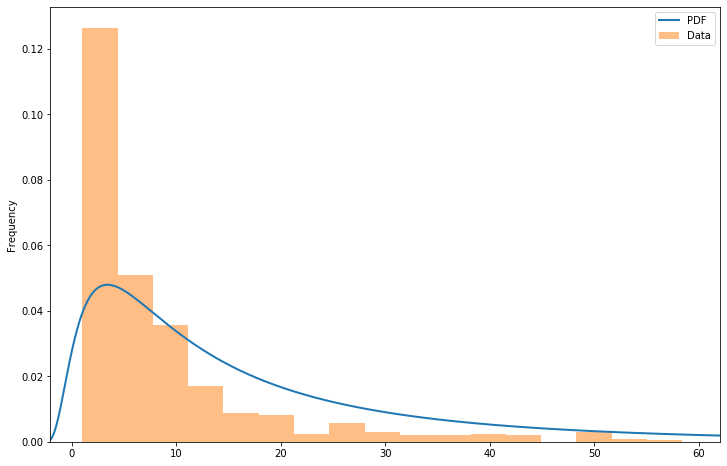

In [170]:
# Display - this is an extreme distribution, so it's best to trust the SSE number.
plt.figure(figsize=(12,8))
ax = ppdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

In [174]:
# The heavy-tailed distributions return negative mean and variance
# this indicates they are infinite.  The Wald has a good shape and has finite mean and variance.
(arg, loc, scale)
m1 = distribution.median(*arg, loc=loc, scale=scale)
m1
m1 = distribution.std(*arg, loc=loc, scale=scale)
m1
m0 = distribution.stats(*arg, loc=loc, scale=scale, moments='mvsk')
m0

((), -3.3586589468247747, 22.376324193541645)

11.76418521279839

22.376324193541645

(array(19.01766525), array(500.69988441), array(3.), array(15.))

In [173]:
?st.wald

Signature:       st.wald(*args, **kwds)
Type:            wald_gen
String form:     <scipy.stats._continuous_distns.wald_gen object at 0x7fc8ec2e3c18>
File:            /misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A Wald continuous random variable.

As an instance of the `rv_continuous` class, `wald` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, loc=0, scale=1)
    Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
logsf(